<a href="https://colab.research.google.com/github/ziednciri/Enhancement-of-Chest-X-ray-Classification-via-Advanced-Deep-Learning-Approaches/blob/main/Projetsiadrm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.1 MB/s eta 0:00:00


# Monter Google Drive et définir les chemins et dossiers

In [ ]:
# ==========================================================
#  1. Monter Google Drive
# ==========================================================
from google.colab import drive
drive.mount('/content/drive')

# ==========================================================
#  2. Définir les chemins et dossiers
# ==========================================================
import os
import pandas as pd

data_dir = "/content/drive/MyDrive/NIH_ChestXray"
csv_path = os.path.join(data_dir, "Data_Entry_2017.csv")

# Lister les sous-dossiers d'images (images_001, images_002, ...)
image_folders = sorted([os.path.join(data_dir, d) for d in os.listdir(data_dir) if "images_" in d])
print(f" {len(image_folders)} dossiers trouvés :", image_folders)

labels_df = pd.read_csv(csv_path)

# Analyse exploratoire du dataset NIH ChestX-ray14

/tmp/ipython-input-3268346863.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_df.index, y=disease_df['Count'], palette="viridis")


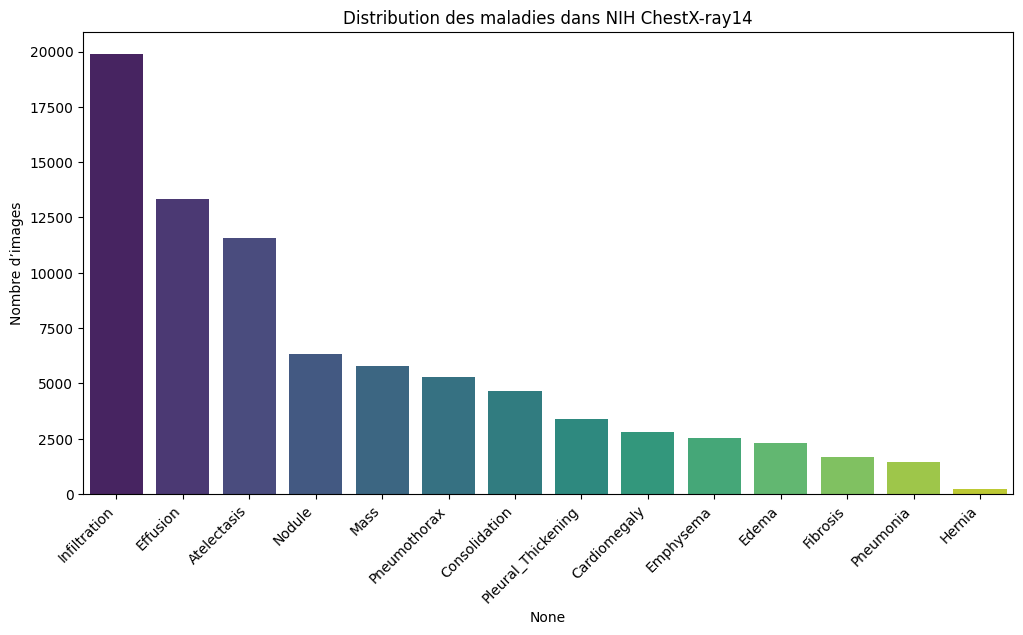

📊 Tableau distribution des maladies :
                    Count
Infiltration        19894
Effusion            13317
Atelectasis         11559
Nodule               6331
Mass                 5782
Pneumothorax         5302
Consolidation        4667
Pleural_Thickening   3385
Cardiomegaly         2776
Emphysema            2516
Edema                2303
Fibrosis             1686
Pneumonia            1431
Hernia                227


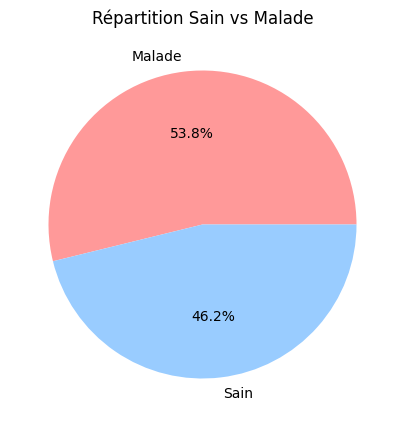

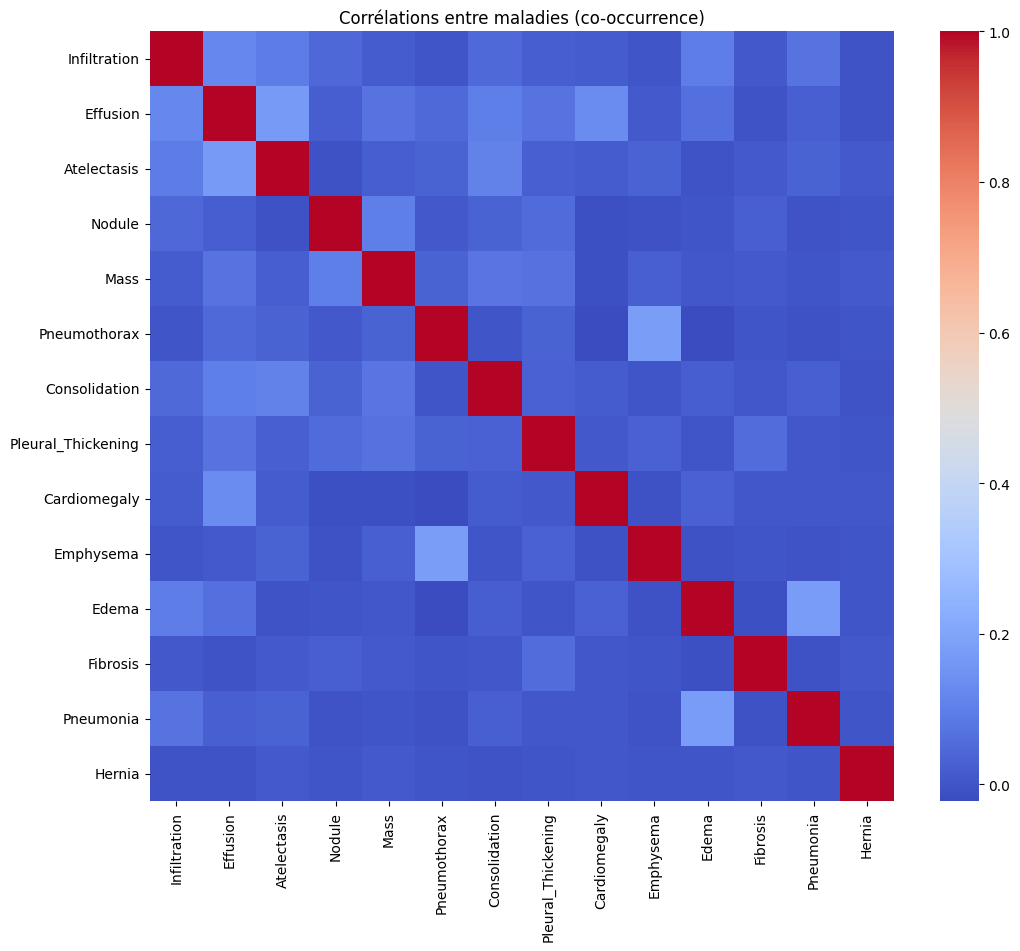

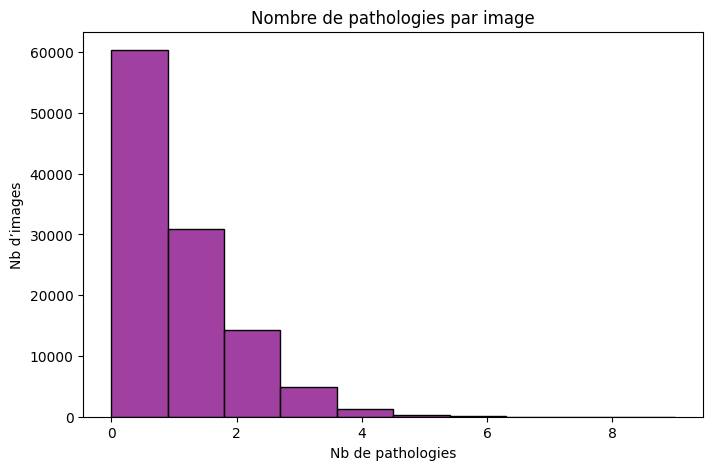

In [ ]:
# ==========================================================
#  Analyse exploratoire du dataset
# ==========================================================
import seaborn as sns
import matplotlib.pyplot as plt

# Recharger dataset complet
labels_df = pd.read_csv(csv_path)
labels_df['Finding Labels'] = labels_df['Finding Labels'].apply(lambda x: x.split('|'))

# === 1. Distribution des maladies ===
from collections import Counter

disease_counts = Counter([d for sublist in labels_df['Finding Labels'] for d in sublist if d != "No Finding"])
disease_df = pd.DataFrame.from_dict(disease_counts, orient='index', columns=['Count']).sort_values("Count", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=disease_df.index, y=disease_df['Count'], palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution des maladies dans NIH ChestX-ray14")
plt.ylabel("Nombre d’images")
plt.show()

print(" Tableau distribution des maladies :")
print(disease_df)

# === 2. Répartition No Finding vs Malades ===
labels_df['is_healthy'] = labels_df['Finding Labels'].apply(lambda x: 1 if "No Finding" in x else 0)
healthy_vs_disease = labels_df['is_healthy'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(healthy_vs_disease, labels=["Malade","Sain"], autopct='%1.1f%%', colors=["#FF9999","#99CCFF"])
plt.title("Répartition Sain vs Malade")
plt.show()

# === 3. Corrélations entre maladies (co-occurrence) ===
from itertools import combinations
import numpy as np

# Créer matrice binaire
diseases = disease_df.index.tolist()
binary_matrix = np.zeros((len(labels_df), len(diseases)))

for i, row in enumerate(labels_df['Finding Labels']):
    for j, d in enumerate(diseases):
        if d in row:
            binary_matrix[i,j] = 1

corr_matrix = np.corrcoef(binary_matrix.T)

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, xticklabels=diseases, yticklabels=diseases, cmap="coolwarm", annot=False)
plt.title("Corrélations entre maladies (co-occurrence)")
plt.show()

# === 4. Histogramme du nombre de pathologies par patient ===
labels_df["n_pathologies"] = labels_df['Finding Labels'].apply(lambda x: len([d for d in x if d != "No Finding"]))
plt.figure(figsize=(8,5))
sns.histplot(labels_df["n_pathologies"], bins=10, kde=False, color="purple")
plt.title("Nombre de pathologies par image")
plt.xlabel("Nb de pathologies")
plt.ylabel("Nb d’images")
plt.show()



## **Analyse exploratoire du dataset NIH ChestX-ray14 par dossier**

✅ 4989 images trouvées dans le dossier /content/drive/MyDrive/NIH_ChestXray/images_001


/tmp/ipython-input-3733859735.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_df.index, y=disease_df['Count'], palette="viridis")


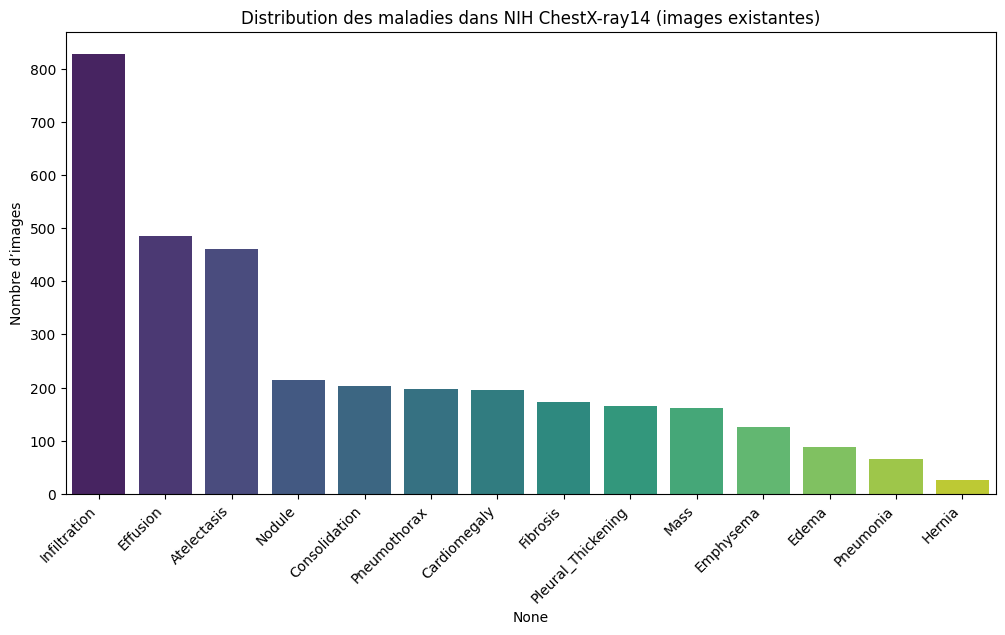

⚖️ Déséquilibre des classes (top 10) :
                    Count  Pourcentage
Infiltration          828    16.596512
Effusion              485     9.721387
Atelectasis           460     9.220285
Nodule                214     4.289437
Consolidation         203     4.068952
Pneumothorax          198     3.968731
Cardiomegaly          195     3.908599
Fibrosis              172     3.447585
Pleural_Thickening    165     3.307276
Mass                  161     3.227100


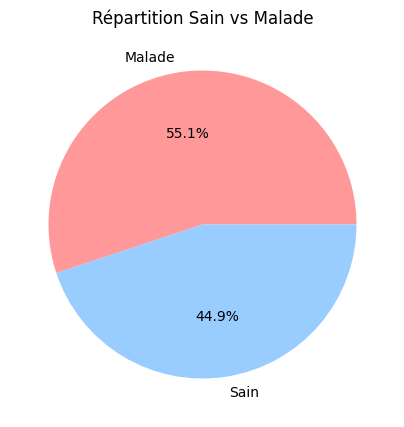

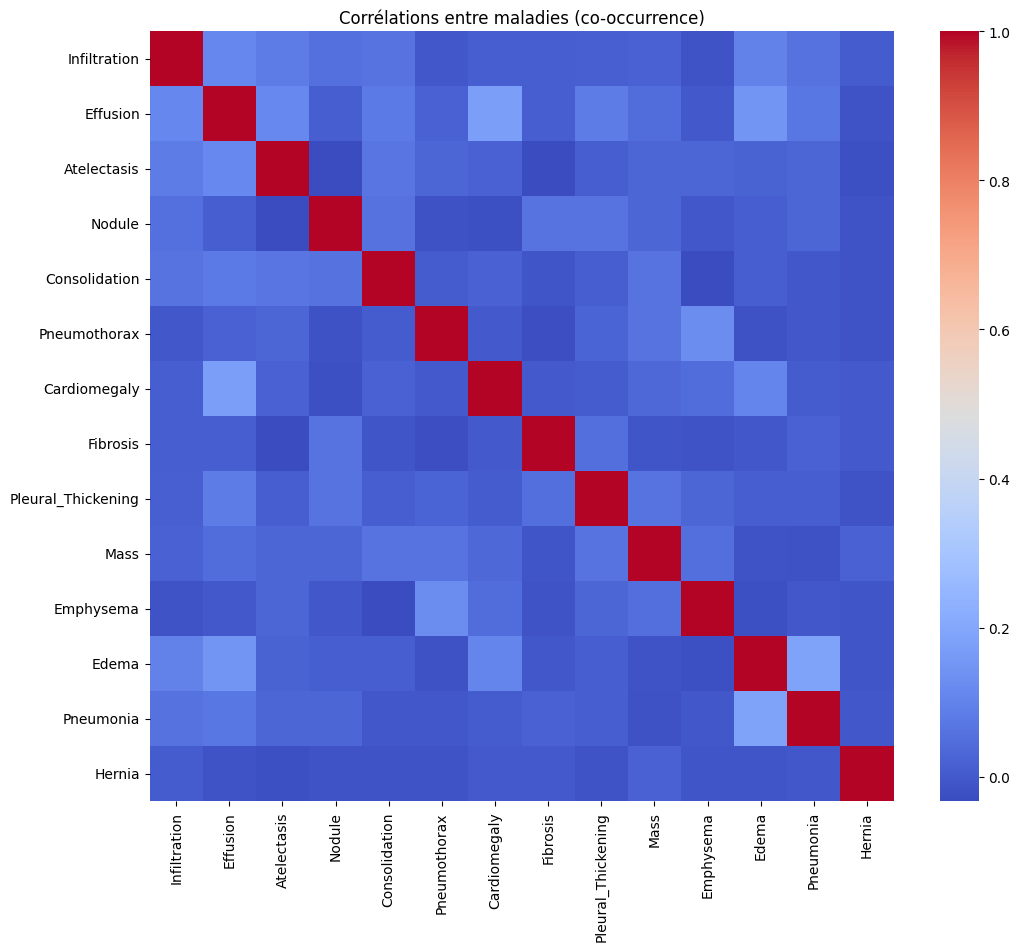

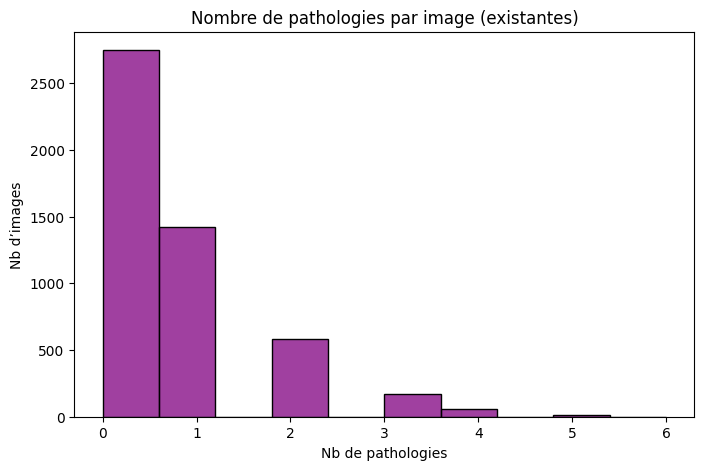

📏 Lecture des dimensions (échantillon de 1000 images max)...


100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]


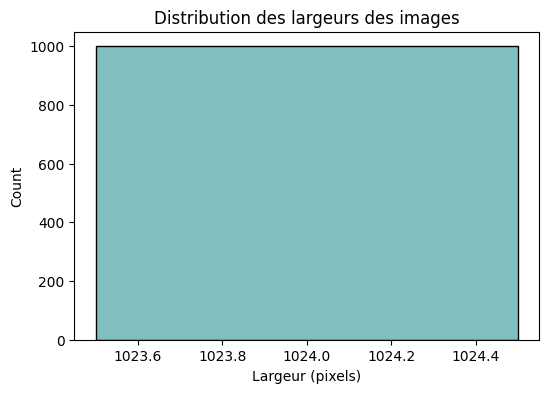

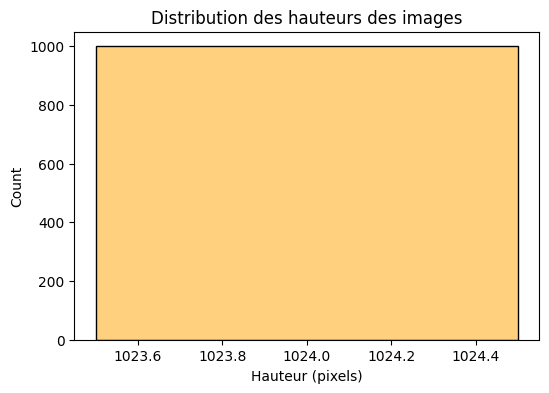

📏 Moyenne largeur : 1024.0px | hauteur : 1024.0px


/tmp/ipython-input-3733859735.py:140: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


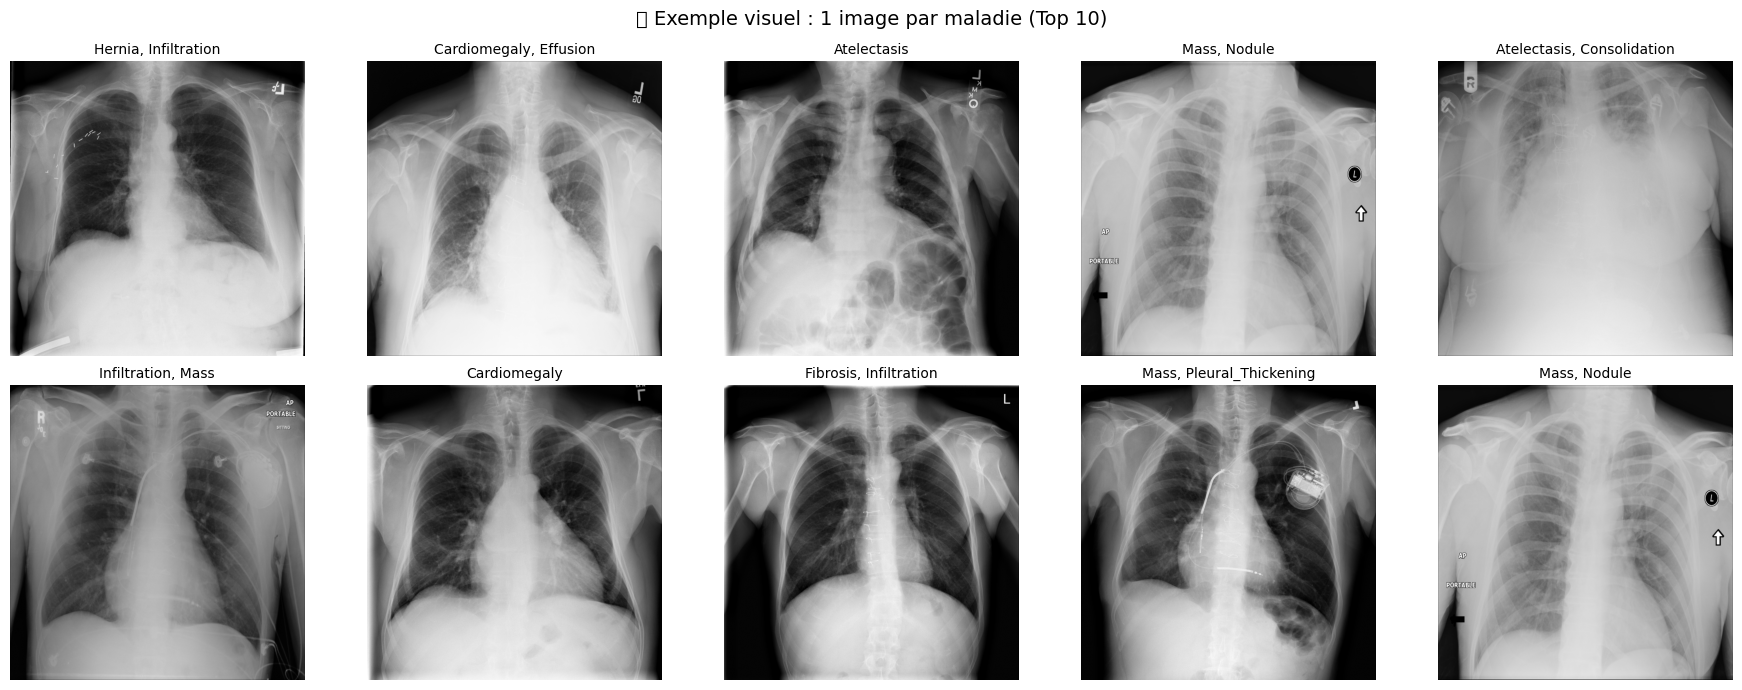

In [ ]:
# ==========================================================
#  Analyse exploratoire complète (préparation au prétraitement)
# ==========================================================
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tqdm import tqdm

# === 0. Chargement du dataset ===
data_dir = "/content/drive/MyDrive/NIH_ChestXray"
csv_path = os.path.join(data_dir, "Data_Entry_2017.csv")
images_dir = os.path.join(data_dir, "images_001")

# Charger CSV d'annotations
labels_df = pd.read_csv(csv_path)
labels_df['Finding Labels'] = labels_df['Finding Labels'].apply(lambda x: x.split('|'))

# Filtrer uniquement les images existantes
existing_images = set(os.listdir(images_dir))
labels_df = labels_df[labels_df["Image Index"].isin(existing_images)]
print(f" {len(labels_df)} images trouvées dans le dossier {images_dir}")

# ==========================================================
#  1. Distribution des maladies
# ==========================================================
disease_counts = Counter([d for sublist in labels_df['Finding Labels'] for d in sublist if d != "No Finding"])
disease_df = pd.DataFrame.from_dict(disease_counts, orient='index', columns=['Count']).sort_values("Count", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=disease_df.index, y=disease_df['Count'], palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution des maladies dans NIH ChestX-ray14 (images existantes)")
plt.ylabel("Nombre d’images")
plt.show()

#  Analyse d’équilibre des classes
total_images = len(labels_df)
disease_df["Pourcentage"] = (disease_df["Count"] / total_images) * 100
print(" Déséquilibre des classes (top 10) :")
print(disease_df.head(10))

# ==========================================================
#  2. Répartition Sain vs Malade
# ==========================================================
labels_df['is_healthy'] = labels_df['Finding Labels'].apply(lambda x: 1 if "No Finding" in x else 0)
healthy_vs_disease = labels_df['is_healthy'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(healthy_vs_disease, labels=["Malade","Sain"], autopct='%1.1f%%', colors=["#FF9999","#99CCFF"])
plt.title("Répartition Sain vs Malade")
plt.show()

# ==========================================================
#  3. Corrélations entre maladies
# ==========================================================
diseases = disease_df.index.tolist()
binary_matrix = np.zeros((len(labels_df), len(diseases)))

for i, row in enumerate(labels_df['Finding Labels']):
    for j, d in enumerate(diseases):
        if d in row:
            binary_matrix[i, j] = 1

corr_matrix = np.corrcoef(binary_matrix.T)
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, xticklabels=diseases, yticklabels=diseases, cmap="coolwarm", annot=False)
plt.title("Corrélations entre maladies (co-occurrence)")
plt.show()

# ==========================================================
#  4. Nombre de pathologies par image
# ==========================================================
labels_df["n_pathologies"] = labels_df['Finding Labels'].apply(lambda x: len([d for d in x if d != "No Finding"]))
plt.figure(figsize=(8,5))
sns.histplot(labels_df["n_pathologies"], bins=10, kde=False, color="purple")
plt.title("Nombre de pathologies par image (existantes)")
plt.xlabel("Nb de pathologies")
plt.ylabel("Nb d’images")
plt.show()

# ==========================================================
#  5. Analyse des tailles d'images
# ==========================================================
widths, heights = [], []

print("📏 Lecture des dimensions (échantillon de 1000 images max)...")
for img_name in tqdm(labels_df["Image Index"].sample(min(1000, len(labels_df)))):
    try:
        img_path = os.path.join(images_dir, img_name)
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except:
        pass

plt.figure(figsize=(6,4))
sns.histplot(widths, kde=True, color='teal')
plt.title("Distribution des largeurs des images")
plt.xlabel("Largeur (pixels)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(heights, kde=True, color='orange')
plt.title("Distribution des hauteurs des images")
plt.xlabel("Hauteur (pixels)")
plt.show()

print(f" Moyenne largeur : {np.mean(widths):.1f}px | hauteur : {np.mean(heights):.1f}px")

# ==========================================================
#  6. Exemple visuel : 1 image par maladie (Top 10)
# ==========================================================
top10_diseases = disease_df.head(10).index.tolist()
sample_images = []

for disease in top10_diseases:
    subset = labels_df[labels_df['Finding Labels'].apply(lambda lst: disease in lst)]
    if not subset.empty:
        sample_images.append(subset.iloc[0])

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.flatten()

for i, row in enumerate(sample_images):
    img_path = os.path.join(images_dir, row["Image Index"])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(", ".join([d for d in row['Finding Labels'] if d != "No Finding"][:2]), fontsize=10)
    else:
        axes[i].text(0.5, 0.5, "Image manquante", ha="center", va="center", fontsize=8)
    axes[i].axis("off")

plt.suptitle("🩻 Exemple visuel : 1 image par maladie (Top 10)", fontsize=14)
plt.tight_layout()
plt.show()


# **Prétraitement et Augmentation**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 1 dossiers trouvés : ['/content/drive/MyDrive/NIH_ChestXray/images_001']

📦 Analyse du dossier : images_001


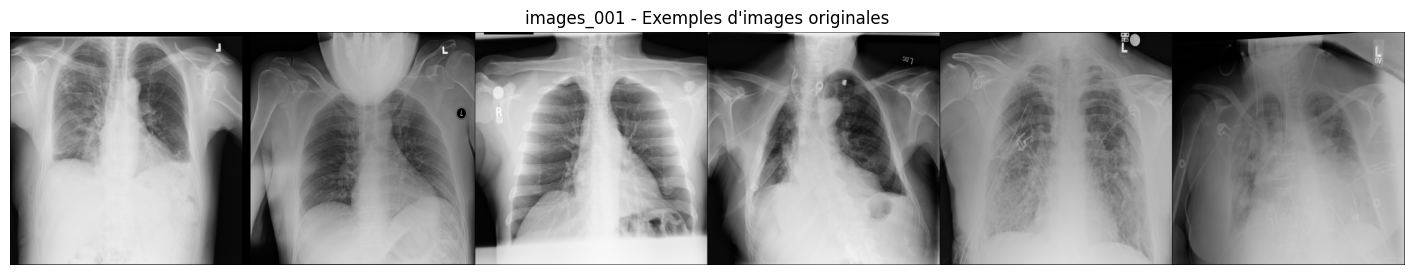

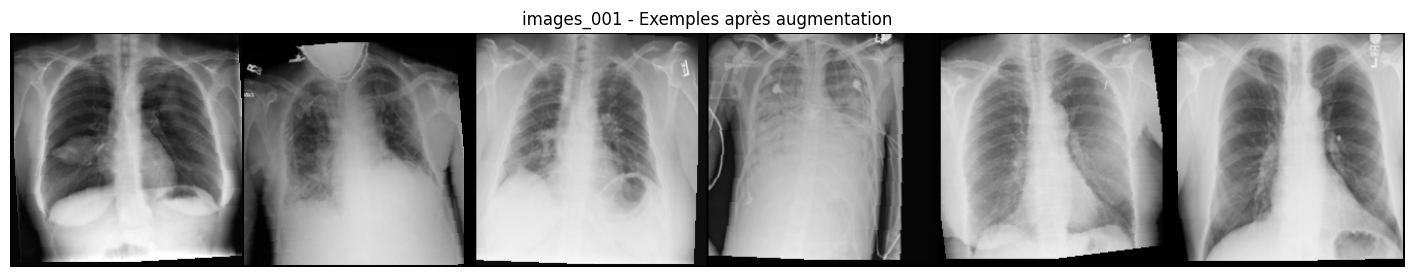

📈 Moyenne : [4.993523816665402e-07, 4.993523816665402e-07, 4.993523816665402e-07] | Écart-type : [0.00023239788424689323, 0.00023239788424689323, 0.00023239788424689323]


,folder,mean,std
0,images_001,"[4.993523816665402e-07, 4.993523816665402e-07,...","[0.00023239788424689323, 0.0002323978842468932..."


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


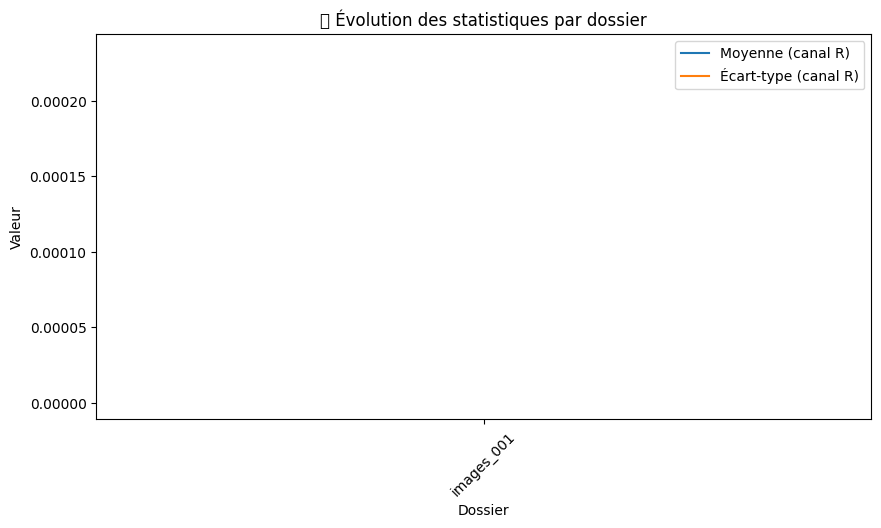

In [ ]:
# ==========================================================
#  1. Monter Google Drive
# ==========================================================
from google.colab import drive
drive.mount('/content/drive')

# ==========================================================
#  2. Définir les chemins et dossiers
# ==========================================================
import os
import pandas as pd

data_dir = "/content/drive/MyDrive/NIH_ChestXray"
csv_path = os.path.join(data_dir, "Data_Entry_2017.csv")

# Lister les sous-dossiers d'images (images_001, images_002, ...)
image_folders = sorted([os.path.join(data_dir, d) for d in os.listdir(data_dir) if "images_" in d])
print(f" {len(image_folders)} dossiers trouvés :", image_folders)

labels_df = pd.read_csv(csv_path)

# ==========================================================
#  3. Dataset et Loader
# ==========================================================
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Image Index"])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(int(row["Finding Labels"] != "No Finding")).long()
        if self.transform:
            image = self.transform(image)
        return image, label

# ==========================================================
#  4. Prétraitement et Augmentation
# ==========================================================
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# --- Transformations ---
basic_tf = transforms.ToTensor()

transform_final = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5174]*3, [0.2298]*3)
])

augment_tf = transforms.Compose([
    transforms.Resize((256, 256)),            # Resize uniforme
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Crop léger, zoom contrôlé
    transforms.RandomRotation(10),            # Rotation légère OK
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05)                # Translation stable
    ),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])    # ChestXray est en niveau de gris, un seul canal
])

# ==========================================================
#  5. Fonction utilitaire pour stats et visualisation
# ==========================================================
def compute_dataset_stats(dataloader, max_batches=50):
    n_pixels = 0
    mean = 0.
    var = 0.
    for i, (imgs, _) in enumerate(dataloader):
        if i >= max_batches: break
        imgs = imgs.view(imgs.size(0), imgs.size(1), -1)
        n_pixels += imgs.size(0) * imgs.size(2)
        mean += imgs.mean(2).sum(0)
        var += imgs.var(2).sum(0)
    mean /= n_pixels
    std = torch.sqrt(var / n_pixels)
    return mean, std

# ==========================================================
#  6. Boucle dossier par dossier
# ==========================================================
stats_list = []

for folder in image_folders:
    folder_name = os.path.basename(folder)
    print(f"\n Analyse du dossier : {folder_name}")

    # Extraire les images correspondant à ce dossier
    images_in_folder = [f for f in os.listdir(folder) if f.endswith(".png")]
    df_subset = labels_df[labels_df["Image Index"].isin(images_in_folder)]

    if len(df_subset) == 0:
        print(f" Aucun fichier trouvé dans {folder}")
        continue

    # Loader pour un échantillon (limité pour la visualisation)
    sample_loader = DataLoader(
        ChestXrayDataset(df_subset.sample(min(6, len(df_subset))), folder, transform=basic_tf),
        batch_size=6, shuffle=False
    )

    # === Affichage images originales ===
    images, _ = next(iter(sample_loader))
    grid = torchvision.utils.make_grid(images, nrow=6, normalize=True)
    plt.figure(figsize=(18,4))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.axis("off")
    plt.title(f"{folder_name} - Exemples d'images originales")
    plt.show()

    # === Images après augmentation ===
    aug_loader = DataLoader(
        ChestXrayDataset(df_subset.sample(min(6, len(df_subset))), folder, transform=augment_tf),
        batch_size=6, shuffle=False
    )
    images_aug, _ = next(iter(aug_loader))
    grid_aug = torchvision.utils.make_grid(images_aug, nrow=6, normalize=True)
    plt.figure(figsize=(18,4))
    plt.imshow(np.transpose(grid_aug.numpy(), (1,2,0)))
    plt.axis("off")
    plt.title(f"{folder_name} - Exemples après augmentation")
    plt.show()

    # === Statistiques du dossier ===
    mini_loader = DataLoader(
        ChestXrayDataset(df_subset.sample(min(300, len(df_subset))), folder, transform=basic_tf),
        batch_size=16, shuffle=False
    )
    mean, std = compute_dataset_stats(mini_loader)
    print(f" Moyenne : {mean.tolist()} | Écart-type : {std.tolist()}")
    stats_list.append({"folder": folder_name, "mean": mean.tolist(), "std": std.tolist()})

# ==========================================================
#  7. Résumé global
# ==========================================================
stats_df = pd.DataFrame(stats_list)
display(stats_df)

plt.figure(figsize=(10,5))
plt.plot(stats_df["folder"], [m[0] for m in stats_df["mean"]], label="Moyenne (canal R)")
plt.plot(stats_df["folder"], [s[0] for s in stats_df["std"]], label="Écart-type (canal R)")
plt.xticks(rotation=45)
plt.xlabel("Dossier")
plt.ylabel("Valeur")
plt.title(" Évolution des statistiques par dossier")
plt.legend()
plt.show()


#Swin Transformer multi-label, per-folder training with resume-from-previous-folder checkpointing

In [ ]:
# 0) Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 1) Imports
import os, copy, time, numpy as np, pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

try:
    from torchvision.models import swin_t
except:
    import torchvision
    swin_t = getattr(torchvision.models, 'swin_t', None)

# 2) Paths
DATA_DIR = "/content/drive/MyDrive/NIH_ChestXray"
CSV_PATH = os.path.join(DATA_DIR, "Data_Entry_2017.csv")
RESULTS_CSV = os.path.join(DATA_DIR, "training_results_swin.csv")
MODELS_DIR = os.path.join(DATA_DIR, "models_by_folder")
os.makedirs(MODELS_DIR, exist_ok=True)
COMMON_CKPT = os.path.join(MODELS_DIR, "common_checkpoint.pth")

# 3) Hyperparameters
WARMUP_EPOCHS = 5
FINETUNE_EPOCHS = 20
BATCH_SIZE = 32
ACCUM_STEPS = 2
LR_HEAD = 1e-3
LR_FINETUNE = 1e-4
IMG_SIZE = 224
NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = torch.cuda.is_available()
SEED = 42
PATIENCE = 6
WEIGHTS_PRETRAINED = True

torch.manual_seed(SEED)
np.random.seed(SEED)
print("Device:", DEVICE)
print("AMP enabled:", USE_AMP)

# 4) Load CSV & Labels
df = pd.read_csv(CSV_PATH)
df["Finding Labels"] = df["Finding Labels"].astype(str)
all_labels = sorted(set(lab for cell in df["Finding Labels"] for lab in cell.split("|") if lab and lab.strip() != "No Finding"))
for disease in all_labels:
    df[disease] = df["Finding Labels"].apply(lambda x: 1 if disease in x.split("|") else 0)

# Optional pos_weight
pos_weight = None
try:
    pos_counts = df[all_labels].sum(axis=0).values.astype(float)
    neg_counts = len(df) - pos_counts
    pos_weight_arr = (neg_counts / (pos_counts + 1e-6)).astype(np.float32)
    pos_weight = torch.tensor(pos_weight_arr).to(DEVICE)
except: pos_weight = None

# 5) Image folders
image_folders = sorted([os.path.join(DATA_DIR, d) for d in os.listdir(DATA_DIR) if d.startswith("images_")])

# 6) Dataset class
class ChestXrayMultiLabelDataset(Dataset):
    def __init__(self, df, img_folder, label_cols, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_folder = img_folder
        self.label_cols = label_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_folder, row["Image Index"])
        image = Image.open(img_path).convert('L') if os.path.exists(img_path) else Image.new('L', (IMG_SIZE, IMG_SIZE))
        image = image.convert('RGB')
        if self.transform: image = self.transform(image)
        labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
        return image, labels

# 7) Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9,1.0)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
    transforms.ColorJitter(brightness=0.08, contrast=0.08),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# 8) Metrics function
def compute_metrics_multi(y_true, y_probs, threshold=0.5):
    C = y_true.shape[1]
    aucs, precs, recs, f1s = [], [], [], []
    for c in range(C):
        try: aucs.append(roc_auc_score(y_true[:,c], y_probs[:,c]))
        except: aucs.append(np.nan)
        preds = (y_probs[:,c]>=threshold).astype(int)
        precs.append(precision_score(y_true[:,c], preds, zero_division=0))
        recs.append(recall_score(y_true[:,c], preds, zero_division=0))
        f1s.append(f1_score(y_true[:,c], preds, zero_division=0))
    return {"auc_mean":np.nanmean(aucs),"precision_mean":np.mean(precs),"recall_mean":np.mean(recs),"f1_mean":np.mean(f1s)}

# 9) Model builder
def build_swin(num_classes, pretrained=True):
    model = swin_t(weights="IMAGENET1K_V1" if pretrained else None)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, num_classes)
    return model

# 10) Checkpoints & EarlyStopping
class EarlyStopping:
    def __init__(self, patience=6, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = -np.inf
        self.counter = 0
        self.best_state = None
    def step(self, metric, model):
        if metric > self.best + self.min_delta:
            self.best = metric
            self.counter = 0
            self.best_state = copy.deepcopy(model.state_dict())
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

# 11) Training functions
from torch.amp import autocast, GradScaler
scaler = GradScaler(enabled=USE_AMP)

def train_one_epoch(model, loader, optimizer, loss_fn, accum_steps=1):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    for step, (imgs, labels) in enumerate(tqdm(loader, leave=False)):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        with autocast('cuda', enabled=USE_AMP):
            out = model(imgs)
            loss = loss_fn(out, labels) / accum_steps
        scaler.scale(loss).backward()
        if (step + 1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        running_loss += loss.item() * imgs.size(0) * accum_steps
    return running_loss / len(loader.dataset)

def validate(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    all_probs, all_targets = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model(imgs)
            total_loss += loss_fn(out, labels).item() * imgs.size(0)
            all_probs.append(torch.sigmoid(out).cpu().numpy())
            all_targets.append(labels.cpu().numpy())
    total_loss /= len(loader.dataset)
    all_probs = np.vstack(all_probs)
    all_targets = np.vstack(all_targets)
    metrics = compute_metrics_multi(all_targets, all_probs)
    return total_loss, metrics

# 12) Main loop
if not os.path.exists(RESULTS_CSV):
    pd.DataFrame(columns=["Folder","Epoch","TrainLoss","ValLoss","ValAUC","ValPrecision","ValRecall","ValF1"]).to_csv(RESULTS_CSV,index=False)

for folder in image_folders:
    folder_name = os.path.basename(folder)
    imgs_in_folder = set(f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg')))
    df_folder = df[df['Image Index'].isin(imgs_in_folder)].reset_index(drop=True)
    if len(df_folder)==0: continue

    train_df, val_df = train_test_split(df_folder, test_size=0.2, random_state=SEED)
    train_loader = DataLoader(ChestXrayMultiLabelDataset(train_df, folder, all_labels, train_transform),
                              batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=DEVICE.type=='cuda')
    val_loader = DataLoader(ChestXrayMultiLabelDataset(val_df, folder, all_labels, val_transform),
                            batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=DEVICE.type=='cuda')

    # Build model
    model = build_swin(len(all_labels), pretrained=WEIGHTS_PRETRAINED).to(DEVICE)

    # Charger checkpoint commun si existe
    if os.path.exists(COMMON_CKPT):
        model.load_state_dict(torch.load(COMMON_CKPT))
        print(f"[{folder_name}]  Checkpoint commun chargé depuis {COMMON_CKPT}")
    else:
        print(f"[{folder_name}]  Aucun checkpoint commun trouvé, nouveau modèle créé")

    # Warm-up head
    for p in model.parameters(): p.requires_grad=False
    for p in model.head.parameters(): p.requires_grad=True
    optimizer = optim.AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=LR_HEAD)

    for epoch in range(1,WARMUP_EPOCHS+1):
        train_loss = train_one_epoch(model, train_loader, optimizer,
                                     nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss(),
                                     accum_steps=ACCUM_STEPS)
        val_loss, metrics = validate(model, val_loader,
                                     nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss())
        print(f"[Warmup] {folder_name} Epoch {epoch}: TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}, AUC={metrics['auc_mean']:.4f}")

    # Fine-tune full model
    for p in model.parameters(): p.requires_grad=True
    optimizer = optim.AdamW(model.parameters(), lr=LR_FINETUNE, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    early = EarlyStopping(patience=PATIENCE)

    for epoch in range(1,FINETUNE_EPOCHS+1):
        train_loss = train_one_epoch(model, train_loader, optimizer,
                                     nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss(),
                                     accum_steps=ACCUM_STEPS)
        val_loss, metrics = validate(model, val_loader,
                                     nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss())
        print(f"[FT] {folder_name} Epoch {epoch}: TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}, AUC={metrics['auc_mean']:.4f}, F1={metrics['f1_mean']:.4f}")

        scheduler.step(metrics['auc_mean'])
        if early.step(metrics['auc_mean'], model):
            print("Early stopping déclenché.")
            model.load_state_dict(early.best_state)
            break

        # Enregistrer les résultats
        pd.concat([pd.read_csv(RESULTS_CSV),
                   pd.DataFrame([{
                       "Folder":folder_name,"Epoch":epoch,"TrainLoss":train_loss,"ValLoss":val_loss,
                       "ValAUC":metrics['auc_mean'],"ValPrecision":metrics['precision_mean'],
                       "ValRecall":metrics['recall_mean'],"ValF1":metrics['f1_mean']
                   }])], ignore_index=True).to_csv(RESULTS_CSV,index=False)

    # Sauvegarder checkpoint commun après ce dossier
    torch.save(model.state_dict(), COMMON_CKPT)
    print(f"[{folder_name}]  Checkpoint commun sauvegardé dans {COMMON_CKPT}")

    # Sauvegarder modèle spécifique au dossier
    final_ckpt = os.path.join(MODELS_DIR, f"{folder_name}_final_best.pth")
    torch.save(model.state_dict(), final_ckpt)
    print(f"[{folder_name}]  Modèle final sauvegardé: {final_ckpt}")

print(" Training terminé pour tous les dossiers.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# **Évolution des performances Swin Transformer**

Mounted at /content/drive
Dossiers présents : ['images_001' 'images_002' 'images_003' 'images_004' 'images_005'
 'images_006' 'images_007' 'images_008' 'images_009' 'images_010'
 'images_011' 'images_012']
Colonnes disponibles : ['Folder', 'Epoch', 'TrainLoss', 'ValLoss', 'ValAUC', 'ValPrecision', 'ValRecall', 'ValF1']


/tmp/ipython-input-575819632.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


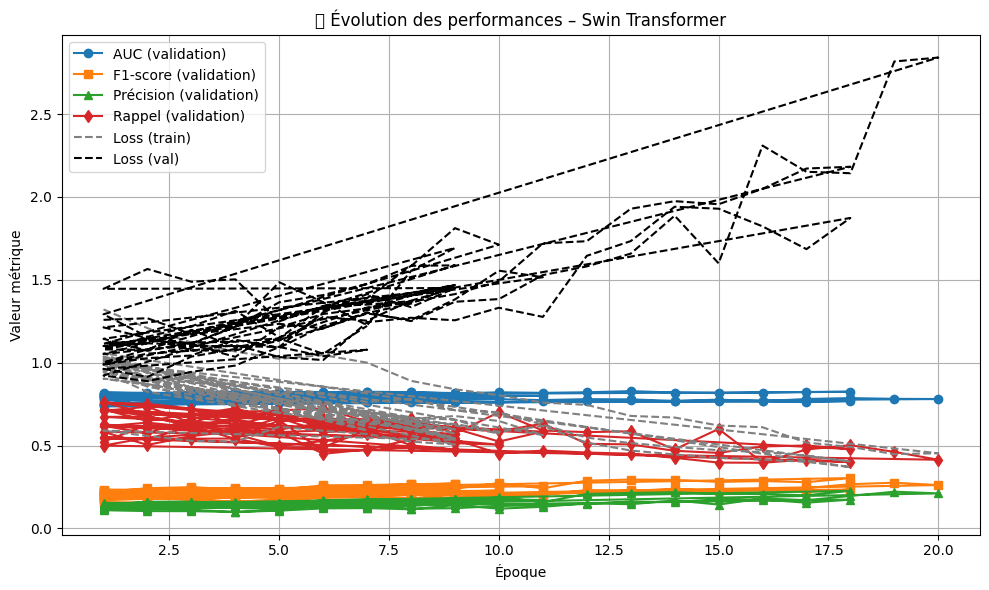

/tmp/ipython-input-575819632.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Folder', y='ValAUC', palette='viridis')


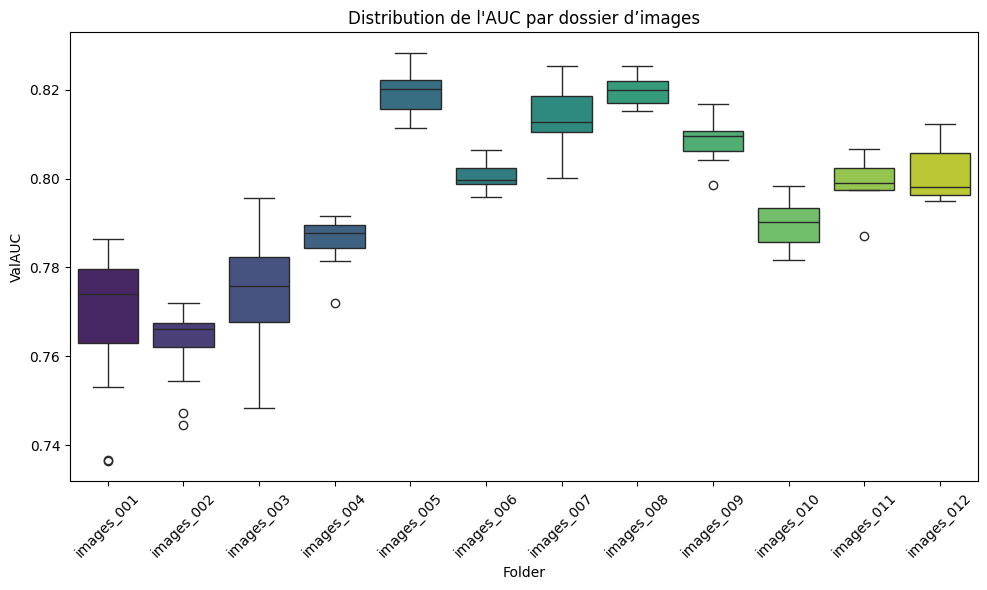

/tmp/ipython-input-575819632.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Folder', y='ValF1', palette='coolwarm')


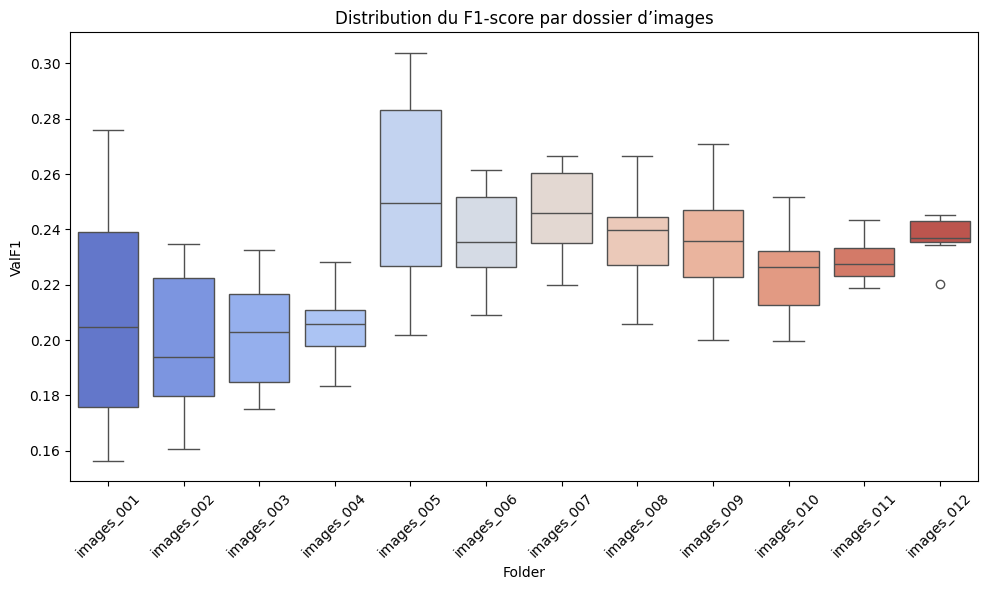

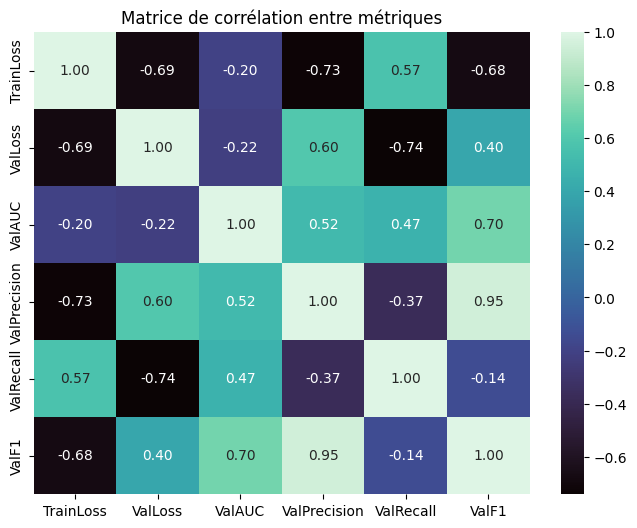

/tmp/ipython-input-575819632.py:95: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


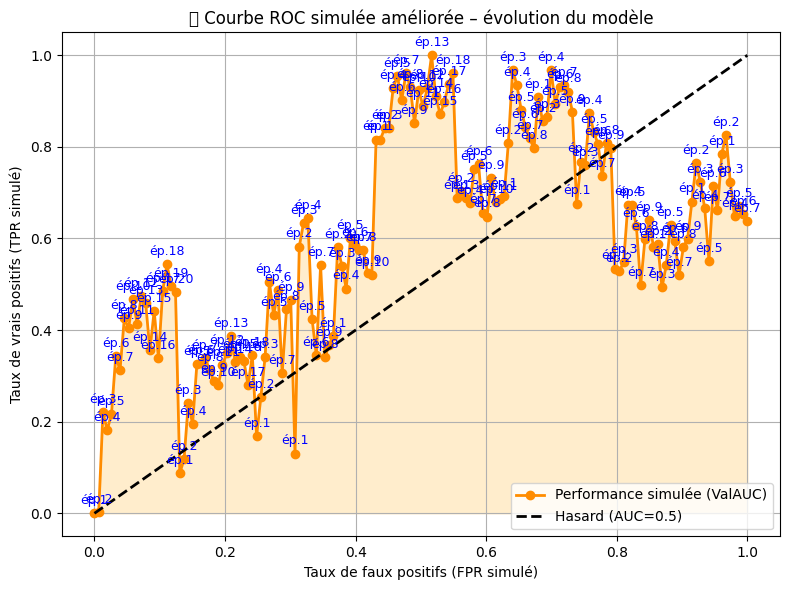

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

 #0) Mount Drive (force to avoid remount warning)
# -----------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# =====================================================
#  Lecture du CSV (déjà monté)
# =====================================================
csv_path = "/content/drive/MyDrive/NIH_ChestXray/training_results_swin.csv"
df = pd.read_csv(csv_path)

print("Dossiers présents :", df['Folder'].unique())
print("Colonnes disponibles :", df.columns.tolist())

# =====================================================
#  Courbes principales par époque (toutes métriques)
# =====================================================
plt.figure(figsize=(10,6))
plt.plot(df['Epoch'], df['ValAUC'], marker='o', label='AUC (validation)')
plt.plot(df['Epoch'], df['ValF1'], marker='s', label='F1-score (validation)')
plt.plot(df['Epoch'], df['ValPrecision'], marker='^', label='Précision (validation)')
plt.plot(df['Epoch'], df['ValRecall'], marker='d', label='Rappel (validation)')
plt.plot(df['Epoch'], df['TrainLoss'], '--', color='gray', label='Loss (train)')
plt.plot(df['Epoch'], df['ValLoss'], '--', color='black', label='Loss (val)')
plt.xlabel('Époque')
plt.ylabel('Valeur métrique')
plt.title(' Évolution des performances – Swin Transformer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
#  Visualisation par dossier ("Folder")
# =====================================================
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Folder', y='ValAUC', palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribution de l'AUC par dossier d’images")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Folder', y='ValF1', palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Distribution du F1-score par dossier d’images")
plt.tight_layout()
plt.show()

# =====================================================
#  Corrélation entre métriques
# =====================================================
corr = df[['TrainLoss','ValLoss','ValAUC','ValPrecision','ValRecall','ValF1']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='mako', fmt=".2f")
plt.title("Matrice de corrélation entre métriques")
plt.show()

# =====================================================
#  Courbe ROC simulée améliorée (à partir du ValAUC)
# =====================================================
import numpy as np

plt.figure(figsize=(8,6))

# Normalisation pour donner une forme plus dynamique
auc_values = df['ValAUC'].values
epochs = df['Epoch'].values

# Simulation : variation progressive du FPR simulé
fpr_sim = np.linspace(0, 1, len(auc_values))
# On rend le TPR simulé proportionnel à l’évolution du ValAUC
tpr_sim = (auc_values - np.min(auc_values)) / (np.max(auc_values) - np.min(auc_values))

# Tracé principal
plt.plot(fpr_sim, tpr_sim, color='darkorange', lw=2, marker='o', label='Performance simulée (ValAUC)')
plt.fill_between(fpr_sim, tpr_sim, alpha=0.2, color='orange')

# Diagonale de hasard
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Hasard (AUC=0.5)')

# Annotation des époques
for i, ep in enumerate(epochs):
    plt.text(fpr_sim[i], tpr_sim[i] + 0.02, f"ép.{ep}", fontsize=9, color='blue', ha='center')

plt.xlabel('Taux de faux positifs (FPR simulé)')
plt.ylabel('Taux de vrais positifs (TPR simulé)')
plt.title(' Courbe ROC simulée améliorée – évolution du modèle')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Installer les librairies nécessaires

In [ ]:
!pip install gradio
!pip install timm
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=665d6bae9d056f114c268e0d173f6642ad5366ea306ccb1c4fadb45f08919975
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


## Chargement du modèle entraîné

In [ ]:
import os, copy, time, numpy as np, pandas as pd
import torch
# 2) Paths
DATA_DIR = "/content/drive/MyDrive/NIH_ChestXray"
MODELS_DIR = os.path.join(DATA_DIR, "models_by_folder")
COMMON_CKPT = os.path.join(MODELS_DIR, "common_checkpoint.pth")

# 1 Construire le modèle
model = build_swin(num_classes=len(all_labels), pretrained=False)

# 2 Charger le checkpoint
checkpoint = torch.load(COMMON_CKPT, map_location=DEVICE)

# Selon la façon dont le modèle a été sauvegardé :
# Si tu as utilisé torch.save(model.state_dict(), PATH)
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)  # checkpoint direct du state_dict

# 3 Envoyer le modèle sur le bon device
model.to(DEVICE)

# 4 Mode évaluation (important pour explicabilité / inference)
model.eval()

print("✔ Modèle chargé et prêt pour l'explicabilité")


✔ Modèle chargé et prêt pour l'explicabilité


# GradCAM++ sur Swin Transformer + Interface Gradio

In [ ]:
print(model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import gradio as gr
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Prétraitement (identique au tien)
# -----------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5174]*3, [0.2298]*3)
])

# -----------------------------
# Grad-CAM++ : couche conv (unique dans ton Swin)
# -----------------------------
target_layer = model.features[0][0]   # Conv2d(3,96)
cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

# -----------------------------
# Hooks pour extraire / recalculer les matrices d'attention
# -----------------------------
_attentions = []  # liste qui contiendra les matrices d'attention par couche (B, heads, L, L)

def attn_forward_hook(module, input, output):
    """
    Hook qui tente de recalculer la matrice d'attention depuis module.qkv.
    Il marche si le module a :
      - module.qkv (nn.Linear)
      - module.num_heads (int)
      - module.scale (float) ou calculable
    """
    try:
        x = input[0]               # shape: (B, L, C)
        qkv = module.qkv(x)        # (B, L, 3*C)
        B, L, threeC = qkv.shape
        C = threeC // 3
        qkv = qkv.reshape(B, L, 3, C).permute(2, 0, 1, 3)  # (3, B, L, C)
        q, k, v = qkv[0], qkv[1], qkv[2]  # each (B, L, C)

        # split heads
        num_heads = getattr(module, "num_heads", None)
        if num_heads is None:
            # essayer d'inférer : souvent C = head_dim * num_heads, head_dim = C // num_heads
            raise RuntimeError("module.num_heads introuvable")
        head_dim = C // num_heads

        q = q.reshape(B, L, num_heads, head_dim).permute(0,2,1,3)  # (B, heads, L, head_dim)
        k = k.reshape(B, L, num_heads, head_dim).permute(0,2,1,3)  # (B, heads, L, head_dim)
        # normaliser/scaler (certaines implémentations stockent module.scale)
        scale = getattr(module, "scale", None)
        if scale is None:
            scale = head_dim ** -0.5

        # calculer attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (B, heads, L, L)
        attn_probs = F.softmax(attn_scores, dim=-1).detach().cpu().numpy()  # to numpy
        _attentions.append(attn_probs)  # append per layer
    except Exception as e:
        # si on ne peut pas recalculer, on ignore silencieusement (mais log utile)
        # print(f"hook skipped: {e}")
        return

# enregistrer hooks sur tous les modules d'attention
_handles = []
for name, module_ in model.named_modules():
    # on cible les modules ShiftedWindowAttention (dans ta structure : attn est l'attribut)
    # on tente d'accrocher aux modules qui possèdent .qkv
    if hasattr(module_, "qkv") and hasattr(module_, "num_heads"):
        h = module_.register_forward_hook(attn_forward_hook)
        _handles.append(h)

# -----------------------------
# Fonctions utilitaires : Rollout et Flow
# -----------------------------
def compute_rollout(attentions, discard_ratio=0.0):
    """
    attentions: list of numpy arrays (B, heads, L, L) in order des couches
    Retourne pour chaque batch un rollout matrix (B, L, L)
    """
    # on moyenne les têtes pour chaque couche -> (B, L, L)
    layers = [att.mean(axis=1) for att in attentions]  # liste shape (B, L, L)
    # pour chaque batch on construit la multiplication matricielle des couches
    B = layers[0].shape[0]
    L = layers[0].shape[1]
    rollout_batch = []
    for b in range(B):
        # construire A_i (avec identité pour residual)
        As = []
        for layer in layers:
            A = layer[b]  # (L, L)
            A = A + np.eye(L)  # ajouter identité pour skip connections
            A = A / A.sum(axis=-1, keepdims=True)  # row-normalize
            As.append(A)
        # multiply from first -> last
        result = As[0]
        for A in As[1:]:
            result = A @ result
        rollout_batch.append(result)
    return np.stack(rollout_batch, axis=0)  # (B, L, L)


def compute_token_importance_from_rollout(rollout_matrix):
    """
    rollout_matrix: (L, L)
    On calcule l'importance d'un token par somme des colonnes (ou moyenne des lignes).
    Retourne vecteur (L,)
    """
    # prendre la somme des influences reçues par chaque token (col-sum)
    importance = rollout_matrix.sum(axis=0)
    importance = (importance - importance.min()) / (importance.max() - importance.min() + 1e-9)
    return importance


# -----------------------------
# Convert tokens -> heatmap image
# -----------------------------
def tokens_to_heatmap(token_importance, image_size=(224,224), patch_size=4):
    """
    token_importance : (L,) where L ~ (H/patch)*(W/patch)
    patch_size : 4 pour Swin avec patch_embed stride 4 (dans ton modèle)
    """
    L = token_importance.shape[0]
    # deviner grid size
    grid = int(np.sqrt(L))
    if grid*grid != L:
        # fallback : essayer factorisation
        # print("Token count non carré; tentative de reshape rectangulaire")
        # on va tenter reshape en (Hpatch, Wpatch) où Hpatch = image_h/patch, Wpatch = image_w/patch
        Hpatch = image_size[0] // patch_size
        Wpatch = image_size[1] // patch_size
        if Hpatch * Wpatch == L:
            grid_h, grid_w = Hpatch, Wpatch
        else:
            grid_h = grid_w = grid  # best-effort
    else:
        grid_h = grid_w = grid

    map2d = token_importance.reshape(grid_h, grid_w)
    # upsample to image size
    map2d = cv2.resize(map2d.astype(np.float32), (image_size[1], image_size[0]), interpolation=cv2.INTER_CUBIC)
    map2d = (map2d - map2d.min()) / (map2d.max() - map2d.min() + 1e-9)
    return map2d  # float 0-1


# -----------------------------
# Main explain function : GradCAM + Attention Rollout + Attention Flow (approx)
def explain_all(pil_img):
    global _attentions
    _attentions = []

    # -----------------------------
    # Prétraitement et prédiction
    # -----------------------------
    rgb_img = np.array(pil_img).astype(np.float32) / 255.0
    input_tensor = preprocess(pil_img).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.sigmoid(output).detach().cpu().numpy()[0]  # (14,)

    # -----------------------------
    # Détection "Healthy"
    # -----------------------------
    threshold = 0.6  # seuil ajustable
    if all(p < threshold for p in probs):
        # Image saine : retourner label et score, pas de heatmap
        return "Healthy", 1.0, None, None, None

    # -----------------------------
    # Classe prédite pour images malades
    # -----------------------------
    predicted_class = int(np.argmax(probs))
    targets = [ClassifierOutputTarget(predicted_class)]

    # Grad-CAM++
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    heatmap_gradcam = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))
    heatmap_gradcam = show_cam_on_image(rgb_img, heatmap_gradcam, use_rgb=True)

    # -----------------------------
    # Forward pass pour hooks attention
    # -----------------------------
    with torch.no_grad():
        _ = model(input_tensor)

    if len(_attentions) == 0:
        return all_labels[predicted_class], float(probs[predicted_class]), heatmap_gradcam, heatmap_gradcam, heatmap_gradcam

    # -----------------------------
    # Attention Rollout
    # -----------------------------
    rollout_batch = compute_rollout(_attentions)
    rollout = rollout_batch[0]
    token_importance = compute_token_importance_from_rollout(rollout)
    attn_rollout_map = tokens_to_heatmap(token_importance, image_size=rgb_img.shape[:2], patch_size=4)
    heatmap_rollout = show_cam_on_image(rgb_img, attn_rollout_map, use_rgb=True)

    # -----------------------------
    # Attention Flow (approximation)
    # -----------------------------
    flow_score = rollout.sum(axis=0)
    flow_score = (flow_score - flow_score.min()) / (flow_score.max() - flow_score.min() + 1e-9)
    attn_flow_map = tokens_to_heatmap(flow_score, image_size=rgb_img.shape[:2], patch_size=4)
    heatmap_flow = show_cam_on_image(rgb_img, attn_flow_map, use_rgb=True)

    # -----------------------------
    # Retour final
    # -----------------------------
    return all_labels[predicted_class], float(probs[predicted_class]), heatmap_gradcam, heatmap_rollout, heatmap_flow
# -----------------------------
# Gradio interface : afficher GradCAM, Rollout et Flow
# -----------------------------
def iface_fn(image):
    return explain_all(image)

interface = gr.Interface(
    fn=iface_fn,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Text(label="Classe prédite"),
        gr.Number(label="Score de confiance"),
        gr.Image(label="Carte Grad-CAM++"),
        gr.Image(label="Attention Rollout"),
        gr.Image(label="Attention Flow (approx.)")
    ],
    title="Swin + Grad-CAM++ + Attention Rollout + Attention Flow",
    description="Upload chest X-ray → Grad-CAM++ (conv) + Attention Rollout + Attention Flow (approx).",
    examples=[["/mnt/data/d1857167-ff19-4b9c-b208-8221fccd4a9c.png"]]
)

interface.launch(share=True, inline=True, prevent_thread_lock=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://028708b08156571126.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
